In [1]:
import os
import os.path as op
from IPython.display import Image

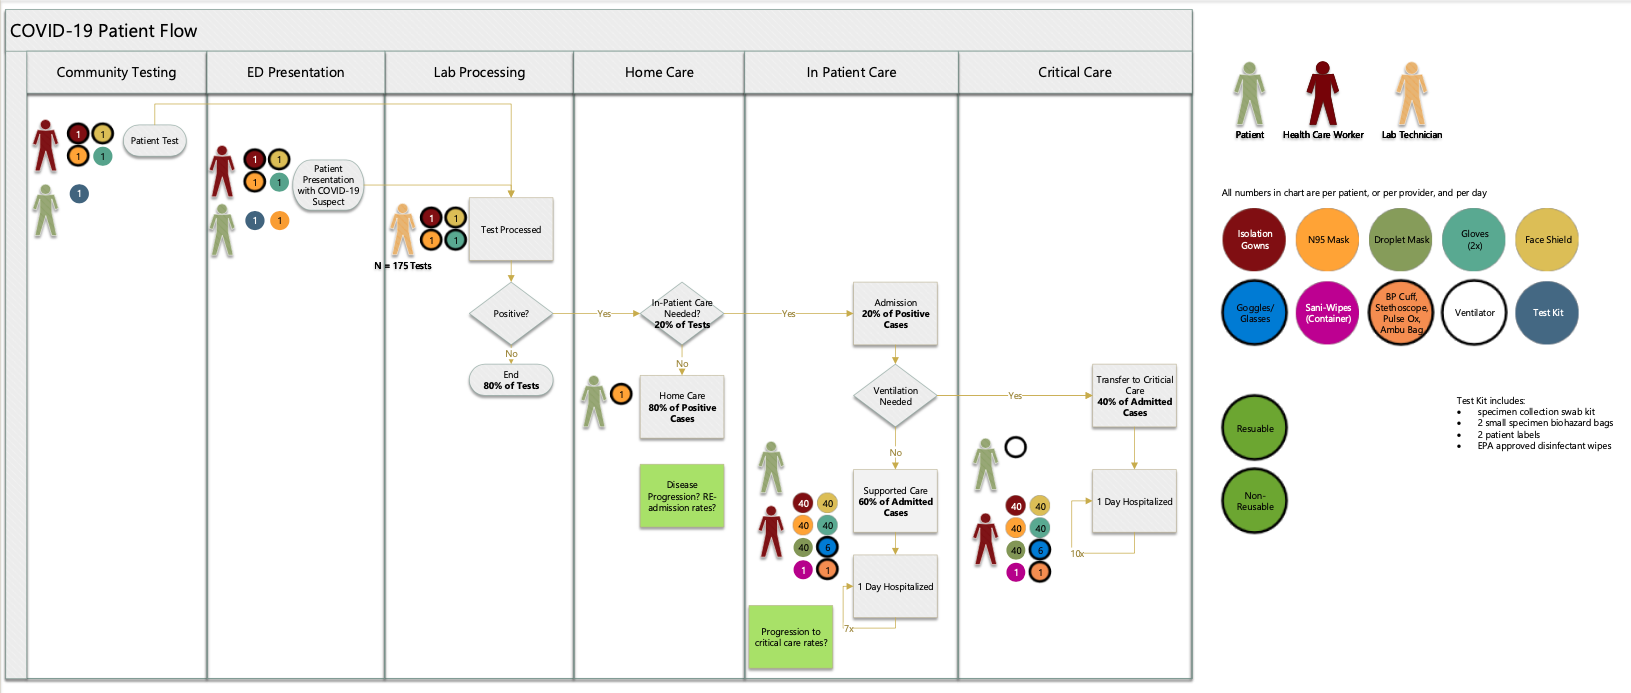

In [2]:
fig_path = "../../figs/"
with open(op.join(fig_path,'covid19_patient_flow_ppes_needs.png'),'rb') as f:
    display(Image(data=f.read(), format='png'))

## Input data

Input data needs to be divided into two groups:

- patients group a who go to community testing;
- patients group b who go to ED presentation;

Ideally, the patients can be daily tracking by each state or hospital. It can be the simulation number that comes from a predictive model, e.g. [SEIR model](https://github.com/alsnhll/SEIR_COVID19/blob/master/SEIR_COVID19.ipynb)

In [3]:
patients_a =2000 # input patients data int(patients_A)
patients_b =3000 # int(patients_B)
patients = patients_a + patients_b
healthcareworkers_a = 100 #int(healthcareworkers_A)
healthcareworkers_b = 200 #int(healthcareworkers_B)
in_patients_days = 7
critical_care_days =  10

positive_rate = 0.2
negative_rate = 1- positive_rate

critical_rate = 0.2
support_care = 0.6

inpatient_care_days = 7
critical_care_days = 10

## patient to lab technician and healthcare workers
patient_tech_ratio = 175 



# PPE use per patients per day from in patient to critical care
haveay_ppe_use = 40
median_ppe_use = 6 
light_ppe_use = 1
double_use = 2

goggles_per_patient = 6
bp_cuff_per_patient = 1
wipers_per_patient = 1


In [4]:
def ppes_community_test(patients_a, healthcareworkers_a):
    """compute PPEs include (N95, gloves, gown, testkit, face shield and ventilator) 
    base on patients and healthcareworkers’ cosupution in ED
    
    Args:
        patients_a (int): number of patients;
        healthcareworkers_a: number of healthcare workers
        
    Returns:
        total_ppes_community (dictionary): PPE needs for community test
    """

    n95_needs = healthcareworkers_a
    gloves = healthcareworkers_a
    testkits =  patients_a
    gowns =  healthcareworkers_a
    faceshields = healthcareworkers_a
    total_ppes_community = dict(N95s= n95_needs, Gloves =gloves, Testkits = testkits, Gowns=gowns,
                         Faceshields=faceshields)
    
    return total_ppes_community

def ppes_ed_presentation(patients_b, healthcareworkers_b):
    """compute PPEs include (N95, gloves, gown, testkit, face shield and ventilator) 
    base on patients and healthcareworkers’ cosupution in ED
    
    Args:
        patients_b (int): number of patients;
        healthcareworkers_b: number of healthcare workers
        
    Returns:
        total_ppes_ed (dictionary): PPE needs for ED presentation
    """

    n95_needs = patients_b + healthcareworkers_b
    gloves = healthcareworkers_b
    testkits =  patients_b
    gowns =  healthcareworkers_b
    faceshields = healthcareworkers_b
    total_ppes_ed = dict(N95s= n95_needs, Gloves =gloves, Testkits = testkits, Gowns=gowns,
                         Faceshields=faceshields)
    
    return total_ppes_ed


def ppes_lab_processing(patients): 
    """to compute the ppes needs during the lab processing
    Args:
        patients (int): number of total patients from community test and ED presentation;
        
    Returns:
        total_ppes_lab (dictionary): PPE needs for lab processing
    """
    technicians = patients/patient_tech_ratio # each technician can run 175 test per day. 
    n95_needs = int(technicians)
    gloves =  int(technicians)
    gowns =  int(technicians)
    faceshields = int(technicians) 

    total_ppes_lab = dict(N95=n95_needs, Gloves= gloves, Gown=gowns, 
                          Faceshields= faceshields)

    return total_ppes_lab


def ppes_home_care(patients):
    """to compute ppe needs during the homecare
    Args:
        patients (int): number of total patients from community test and ED presentation;
        
    Returns:
        total_ppes_homecare (dictionary): PPE needs for home care
    """

    #20% endup being positive and 80% of these in home care
    home_care_patients = patients * positive_rate * negative_rate        
    n95_needs = int(home_care_patients)

    total_ppes_homecare = dict(N95s = n95_needs)
    return total_ppes_homecare


def ppes_in_patient_care(patients, in_patients_days):
    """to compute ppe needs during in patient care
    Args:
        patients (int): number of total patients from community test and ED presentation;
        in_patients_days(int): number of days each person will need to be in Patient Care
        
    Returns:
        total_ppes_in_patient (dictionary): PPE needs for in patient care
    """

    # 20% endup being positive and 20% of these in patient care
    in_patient_patients = int(patients * positive_rate)
    
    #assuming 1 doctor takes care the 7 patients over 7 days - needs to check it with Abi

    healthcareworkers = int(in_patient_patients/7)  # need to do some research

    n95_needs = healthcareworkers * in_patients_days * haveay_ppe_use
    gloves =  healthcareworkers * in_patients_days * haveay_ppe_use * double_use # 2x of 40 per patients 
    gowns = healthcareworkers * in_patients_days * haveay_ppe_use # 40 gowns per paitient
    faceshields = healthcareworkers * in_patients_days * haveay_ppe_use 
    droplet_masks = healthcareworkers * haveay_ppe_use
    goggles =  in_patient_patients * goggles_per_patient # goggle can be reused
    bp_cuff = in_patient_patients * bp_cuff_per_patient # bp cuff, ambu bag can be reused
    wipers = in_patient_patients * wipers_per_patient

    total_ppes_in_patient = dict(N95s = n95_needs, Gloves= gloves, Gown=gowns, 
                                 Faceshields= faceshields, Droplet_masks = droplet_masks, 
                                 Goggles = goggles, BP_cuff = bp_cuff, Wiper = wipers)

    return total_ppes_in_patient


def ppes_critical_care(patients, critical_care_days):
    """compute the ventilators and ppe needs based on the critical care patients
    Args:
        patients (int): number of total patients from community test and ED presentation;
        in_patients_days(int): number of days each person will need to be in Critical Care
        
    Returns:
        total_ppes_criticalcare (dictionary): PPE needs for in critical care
    """

    # 40% of in patient patients end up in critical care
    critical_care_patients = int(patients * positive_rate * critical_rate)
    
    ventilators = int(critical_care_patients)
    healthcareworkers = int(critical_care_patients/4) # need to recheck the data on patients/doctor ratio

    # assuming 1 doctor takes care the 3 patients over 10 days- needs to check it with Abi 
    n95_needs = healthcareworkers * critical_care_days * haveay_ppe_use
    gloves =  healthcareworkers * critical_care_days * haveay_ppe_use * double_use # 2x of 40 per patients 
    gowns = healthcareworkers * critical_care_days * haveay_ppe_use # 40 gowns per paitient
    faceshields = healthcareworkers * critical_care_days * haveay_ppe_use
    droplet_masks = healthcareworkers * haveay_ppe_use
    goggles =  critical_care_patients * goggles_per_patient # goggle can be reused
    bp_cuff = critical_care_patients * bp_cuff_per_patient # bp cuff, ambu bag can be reused
    wipers = critical_care_patients * wipers_per_patient

    total_ppes_criticalcare = dict(N95s = n95_needs, Gloves= gloves, Gown=gowns, 
                                 Faceshields= faceshields, Droplet_masks = droplet_masks, 
                                 Goggles = goggles, BP_cuff = bp_cuff, Wiper = wipers,
                                 Ventilators = ventilators)
    
    return total_ppes_criticalcare


In [5]:
total_ppes_community = ppes_community_test(patients_a, healthcareworkers_a)
total_ppes_community

{'N95s': 100,
 'Gloves': 100,
 'Testkits': 2000,
 'Gowns': 100,
 'Faceshields': 100}

In [6]:
total_ppes_ed = ppes_ed_presentation(patients_b, healthcareworkers_b)
total_ppes_ed

{'N95s': 3200,
 'Gloves': 200,
 'Testkits': 3000,
 'Gowns': 200,
 'Faceshields': 200}

In [7]:
total_ppes_lab = ppes_lab_processing(patients)
total_ppes_lab

{'N95': 28, 'Gloves': 28, 'Gown': 28, 'Faceshields': 28}

In [8]:
total_ppes_homecare = ppes_home_care(patients)
total_ppes_homecare

{'N95s': 800}

In [9]:
total_ppes_in_patient = ppes_in_patient_care(patients, in_patients_days)
total_ppes_in_patient

{'N95s': 39760,
 'Gloves': 79520,
 'Gown': 39760,
 'Faceshields': 39760,
 'Droplet_masks': 5680,
 'Goggles': 6000,
 'BP_cuff': 1000,
 'Wiper': 1000}

In [10]:
total_ppes_criticalcare = ppes_critical_care(patients, critical_care_days)
total_ppes_criticalcare

{'N95s': 20000,
 'Gloves': 40000,
 'Gown': 20000,
 'Faceshields': 20000,
 'Droplet_masks': 2000,
 'Goggles': 1200,
 'BP_cuff': 200,
 'Wiper': 200,
 'Ventilators': 200}